In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import msise00
from datetime import datetime
from scipy.interpolate import interp1d

In [3]:
glat = 0.0
glon = 0.0
alt_km = np.arange(0.0, 2110, 20.0)
time = datetime(2013, 12, 13, 13, 0, 0)

atmos = msise00.run(time, alt_km, glat, glon)

ATM_height = atmos.alt_km
ATM_density= atmos.Total[0,:,0,0]

In [4]:
atmos = msise00.run(time, alt_km, glat, glon)


ATM_height = atmos.alt_km
ATM_density= atmos.Total[0,:,0,0]

density_int   = interp1d(ATM_height*1E3, ATM_density, kind='linear', fill_value=100.0, bounds_error=False)

In [5]:
import iri2016.altitude as iri

sim=iri.main(time, (200.0, 2110, 20.0), 0, 0)

alt_arr    = sim['alt_km']
nO_arr     = sim['nO+']
nH_arr     = sim['nH+']

mass_density = (sim['nO+']*16+sim['nH+']*1.0)*1.67E-27

mass_density_int = interp1d(alt_arr*1E3, mass_density, kind='linear', fill_value=0.0, bounds_error=False)

In [6]:
def compute_rho(altitude):
    return float(density_int(altitude))

In [7]:
def compute_mass_dens(altitude):
    return float(mass_density_int(altitude))

In [8]:
def compute_Md(P,R,A):
    
    Md = np.sqrt(P/R)*A
    
    return Md

In [9]:
def compute_L(Md, rho, v):
    
    return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)

In [10]:
def compute_D(altitude, v, S, CD):
    rho = compute_rho(altitude)
    D = 0.5*rho*v**2*S*CD
    
    if altitude < 0:
        D = 1E2
    
    return D

In [11]:
def compute_mhd_drag(altitude, v, P, R, A, CD):
    rho = compute_mass_dens(altitude)
    
    Md  = compute_Md(P,R,A)
    
   
    L   = compute_L(Md, rho, v)
    S   = np.pi*L**2

    D   = 0.5*rho*v**2*S*CD

    return D

In [12]:
g0 = 9.80665
rP = 6375E3

def compute_g(altitude):
    
    r = altitude + rP
    
    g0 = 3.986E14/(rP**2)
    
    g = g0*(rP/r)**2
    
    if altitude < 0:
        g = 9.80665
        
    return g

In [13]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [14]:
def circularSpeed(altitude):
    
    return np.sqrt(3.986E14/(rP + altitude))

In [15]:
def EOM1(t,y,S,CD,m):
    
    r, v, gamma, phi  = y
    
    D            = compute_D(r - rP, v, S, CD)
    g            = compute_g(r - rP)
    
    dydt         = [v*np.sin(gamma),
                    -1*D/m - 1*g*np.sin(gamma),
                    -1*g*np.cos(gamma)/v + v*np.cos(gamma)/r,
                   v*np.cos(gamma)/r]
    
    return dydt
    

def solveTrajectory1(r0, v0, gamma0, phi0, t_sec, N, tol, S, CD, m):
    
    x0        = [r0, v0, gamma0, phi0]
    t         = np.linspace(0, t_sec, N) 
    
    xbar      = solve_ivp(EOM1, [0,t_sec], x0 ,rtol=tol, atol=tol, args=(S, CD, m), t_eval=np.linspace(0, t_sec, N))
    
    
    t0        = xbar.t
    
    r         = xbar.y[0]
    v         = xbar.y[1]
    gamma     = xbar.y[2]
    phi       = xbar.y[3]
    
    return t0, r, v, gamma, phi

In [16]:
def P(t):
    
    if t%5578 < 3400:
        return 1.4
    else:
        return 0
    
    

def EOM2(t,y,S,R,A,CD1,CD2,m,ff):
    
    r, v, gamma, phi  = y
    
    
    D1            = compute_D(r - rP, v, S, CD1)
    
    D2            = compute_mhd_drag(r-rP, v, P(t), R, A, CD2)*ff
   
    D = D1 + D2
    
    g            = compute_g(r - rP)
    
    dydt         = [v*np.sin(gamma),
                    -1*D/m - 1*g*np.sin(gamma),
                    -1*g*np.cos(gamma)/v + v*np.cos(gamma)/r,
                   v*np.cos(gamma)/r]
    
    return dydt


def solveTrajectory2(r0, v0, gamma0, phi0, t_sec, N, tol, S, R, A, CD1, CD2, m,ff):
    
    x0        = [r0, v0, gamma0, phi0]
    t         = np.linspace(0, t_sec, N) 
    
    xbar      = solve_ivp(EOM2, [0,t_sec], x0, rtol=tol, atol=tol, t_eval=np.linspace(0, t_sec, N), 
                          args=(S, R, A, CD1, CD2, m,ff))
    
    t0        = xbar.t
    r         = xbar.y[0]
    v         = xbar.y[1]
    gamma     = xbar.y[2]
    phi       = xbar.y[3]
    
    return t0, r, v, gamma, phi

In [17]:
t0, r0, v0, gamma0, phi0 = solveTrajectory1(rP+420E3, circularSpeed(420E3), 0.0, 0.0, 100*86400, 10001, 1E-8, 0.01, 2.2, 1.33)
t1, r1, v1, gamma1, phi1 = solveTrajectory2(rP+420E3, circularSpeed(420E3), 0.0, 0.0, 100*86400, 10001, 1E-8, 0.01, 0.1, 2.00, 2.2, 3.6, 1.33, 0.30)
t2, r2, v2, gamma2, phi2 = solveTrajectory2(rP+420E3, circularSpeed(420E3), 0.0, 0.0, 100*86400, 10001, 1E-8, 0.01, 0.1, 2.00, 2.2, 3.6, 1.33, 0.10)
t3, r3, v3, gamma3, phi3 = solveTrajectory2(rP+420E3, circularSpeed(420E3), 0.0, 0.0, 100*86400, 10001, 1E-8, 0.01, 0.1, 2.00, 2.2, 3.6, 1.33, 0.05)
t4, r4, v4, gamma4, phi4 = solveTrajectory2(rP+420E3, circularSpeed(420E3), 0.0, 0.0, 100*86400, 10001, 1E-8, 0.01, 0.1, 2.00, 2.2, 3.6, 1.33, 0.01)

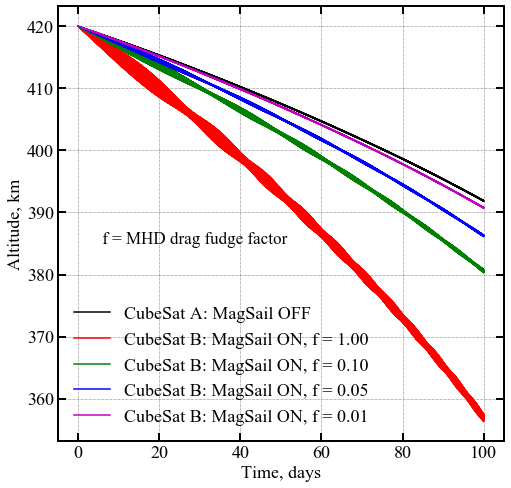

In [25]:
plt.figure(figsize=(8,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)


plt.plot(t0/(86400),(r0-rP)/1E3, 'k', label='CubeSat A: MagSail OFF')
plt.plot(t1/(86400),(r1-rP)/1E3, 'r', label='CubeSat B: MagSail ON, f = 1.00')
plt.plot(t2/(86400),(r2-rP)/1E3, 'g', label='CubeSat B: MagSail ON, f = 0.10')
plt.plot(t3/(86400),(r3-rP)/1E3, 'b', label='CubeSat B: MagSail ON, f = 0.05')
plt.plot(t4/(86400),(r4-rP)/1E3, 'm', label='CubeSat B: MagSail ON, f = 0.01')

ax = plt.gca()

ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')

ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)


ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)

ax.xaxis.set_tick_params(width=1, length=6, which='minor')
ax.yaxis.set_tick_params(width=1, length=6, which='minor')


ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

plt.xlabel('Time, days', fontsize=18)
plt.ylabel('Altitude, km', fontsize=18)

#plt.text(2, 390.0, 'Release altitude = 420 km', fontsize=18)
#plt.text(2, 380.0, 'MagSail On-time = 0.95h per orbit, 44h/48h cycle', fontsize=18)
#plt.text(2, 370.0, 'MagSail P = 1.54 W, Area = 0.5 '+r'$m^2$', fontsize=18)
#plt.text(2, 360.0, 'Total mass = 1.33 kg', fontsize=18)
#plt.text(2, 350.0, 'Wire mass = 75 g; R = 0.008 '+r'$\Omega$', fontsize=18)
#plt.text(2, 350.0, 'Wire mass = 1000 g; R = 0.003 '+r'$\Omega$', fontsize=18)

plt.legend(loc='lower left', fontsize=18, framealpha=0)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

    
plt.text(5,385, ' f = MHD drag fudge factor', fontsize=17)

#plt.ylim([340,460])
#plt.xlim([0,10])


plt.savefig('../new_plots/cubesat-orbit-decay-1U-3.7Wh.png', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/cubesat-orbit-decay-1U-3.7Wh.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/cubesat-orbit-decay-1U-3.7Wh.eps', dpi=300,bbox_inches='tight')

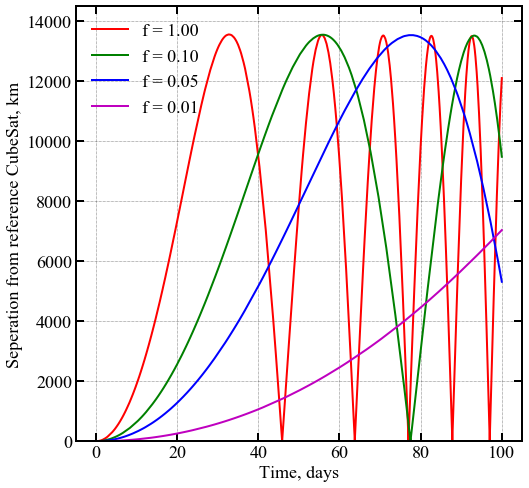

In [24]:
x0 = r0*np.cos(phi0)
y0 = r0*np.sin(phi0)

x1 = r1*np.cos(phi1)
y1 = r1*np.sin(phi1)

x2 = r2*np.cos(phi2)
y2 = r2*np.sin(phi2)

x3 = r3*np.cos(phi3)
y3 = r3*np.sin(phi3)

x4 = r4*np.cos(phi4)
y4 = r4*np.sin(phi4)


d1 = np.sqrt((x1-x0)**2 + (y1-y0)**2)
d2 = np.sqrt((x2-x0)**2 + (y2-y0)**2)
d3 = np.sqrt((x3-x0)**2 + (y3-y0)**2)
d4 = np.sqrt((x4-x0)**2 + (y4-y0)**2)


plt.figure(figsize=(8,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.plot(t0/86400, d1/1E3, color='r', linewidth=2.0, label = 'f = 1.00')
plt.plot(t0/86400, d2/1E3, color='g', linewidth=2.0, label = 'f = 0.10')
plt.plot(t0/86400, d3/1E3, color='b', linewidth=2.0, label = 'f = 0.05')
plt.plot(t0/86400, d4/1E3, color='m', linewidth=2.0, label = 'f = 0.01')


ax = plt.gca()

ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')

ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)


ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)

ax.xaxis.set_tick_params(width=1, length=6, which='minor')
ax.yaxis.set_tick_params(width=1, length=6, which='minor')


ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

plt.xlabel('Time, days', fontsize=18)
plt.ylabel('Seperation from reference CubeSat, km', fontsize=18)

plt.legend(loc='upper left', fontsize=18,  framealpha=0)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

plt.ylim([0, 14500])


plt.savefig('../new_plots/cubesat-relative-sep-1U-3.7Wh.png', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/cubesat-relative-sep-1U-3.7Wh.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../new_plots/cubesat-relative-sep-1U-3.7Wh.eps', dpi=300,bbox_inches='tight')

In [20]:
3.6/0.2

18.0